In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils , plot_utils
# import dynamic_routing_analysis as dra

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

In [9]:
results_path=r's3://aind-scratch-data/dynamic-routing/decoding/results/v265_0_consolidated.parquet'

session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [10]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [75]:
# structure-wise average decoding accuracy

new_results_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').n_unique().ge(3).over('structure', 'unit_subsample_size', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )
    # get the means over sessions:
    .group_by('structure', 'unit_subsample_size', 'unit_criteria')
    .agg(
        pl.col('mean_true').mean(),
        pl.col('mean_true').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_true'),
        pl.col('median_null').mean(),
        pl.col('median_null').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_null'),
        pl.col('mean_diff').mean(),
        pl.col('mean_diff').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_diff'),
        pl.col('session_id').n_unique().alias('num_sessions')
    )
    .sort(pl.col('mean_diff').mean().over('structure'), descending=True)
    .collect()
)



In [76]:
new_results_pd=new_results_df.to_pandas()
new_results_pd

,structure,unit_subsample_size,unit_criteria,mean_true,sem_true,median_null,sem_null,mean_diff,sem_diff,num_sessions
0,SCiw,NaN,loose_drift,0.771471,0.019500,0.634977,0.010596,0.136495,0.011177,30
1,SCiw,10.0,loose_drift,0.760572,0.017992,0.633488,0.010439,0.127084,0.010170,19
2,SCiw,20.0,loose_drift,0.822718,0.016810,0.659734,0.016064,0.162984,0.008591,11
3,SCiw,30.0,loose_drift,0.815342,0.029773,0.640367,0.019355,0.174976,0.011197,5
4,SCm,30.0,loose_drift,0.813534,0.013531,0.653130,0.009225,0.160404,0.008343,20
...,...,...,...,...,...,...,...,...,...,...
406,LSc,40.0,loose_drift,0.547417,0.031098,0.556096,0.022024,-0.008679,0.009177,3
407,LSc,30.0,loose_drift,0.547681,0.019658,0.544166,0.014382,0.003515,0.014896,4
408,LSc,10.0,loose_drift,0.518964,0.014550,0.521049,0.007404,-0.002085,0.010454,5
409,NB,NaN,loose_drift,0.512878,0.011146,0.523976,0.006621,-0.011099,0.008073,3


In [ ]:
# new_results_pd.to_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\structure_wise_decoding_accuracy.csv",index=False)

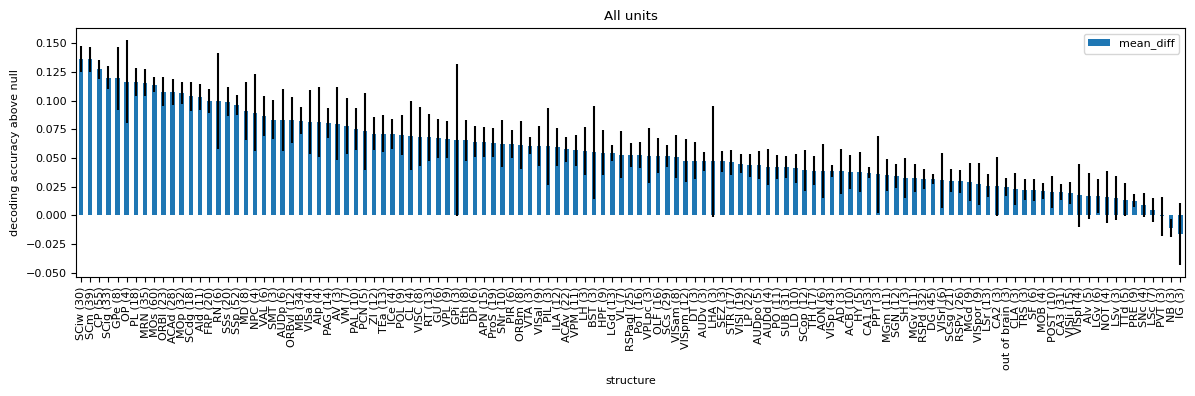

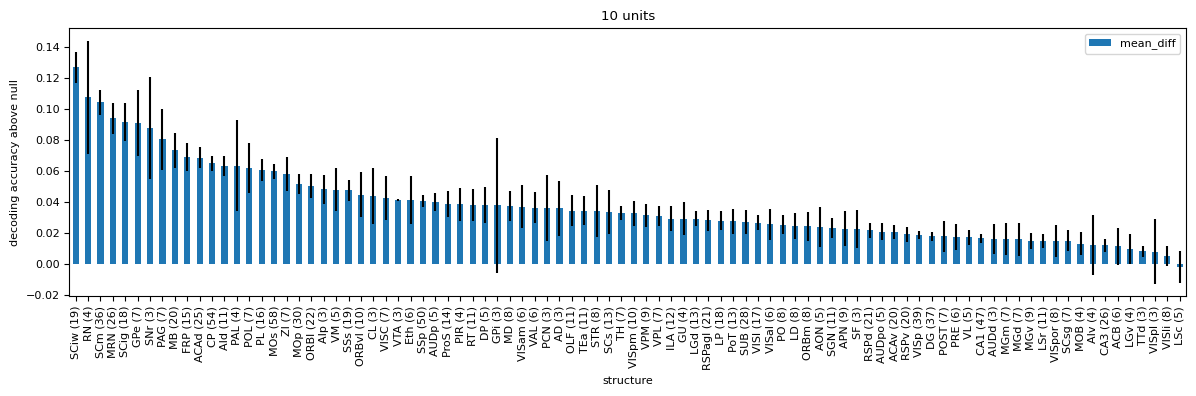

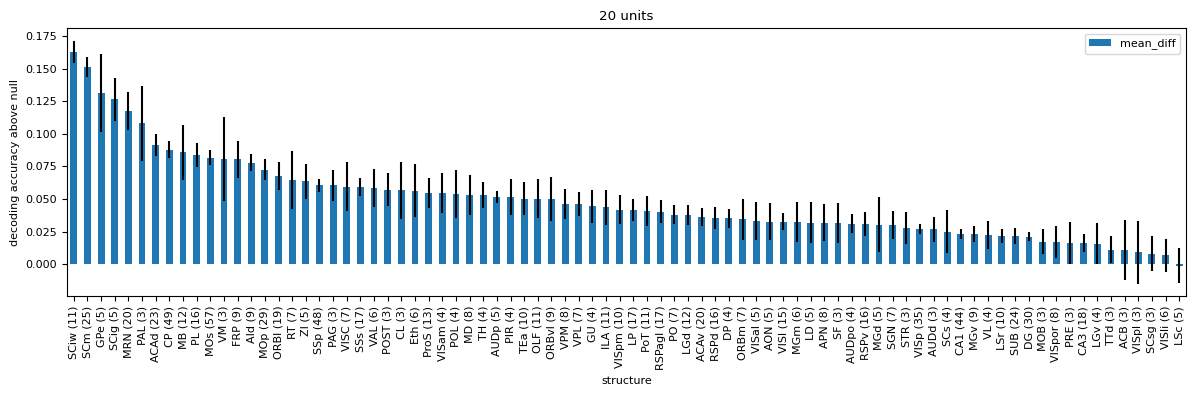

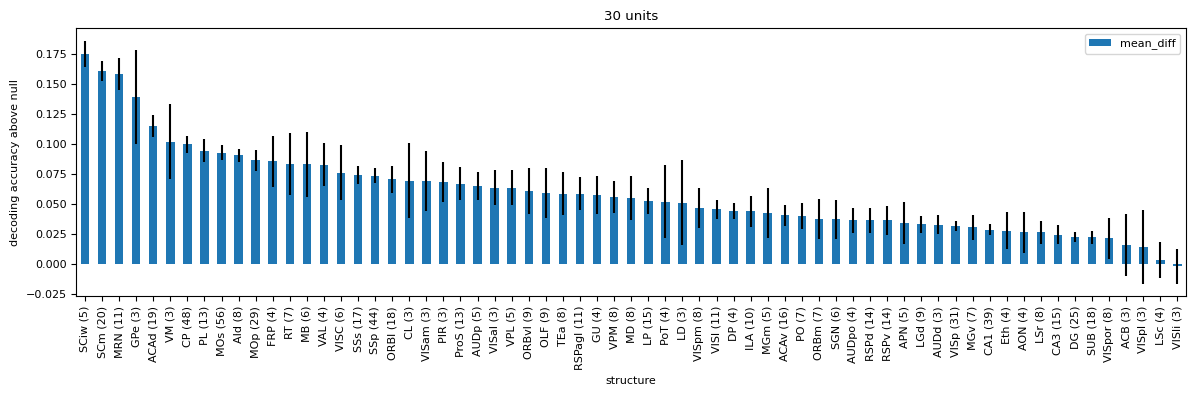

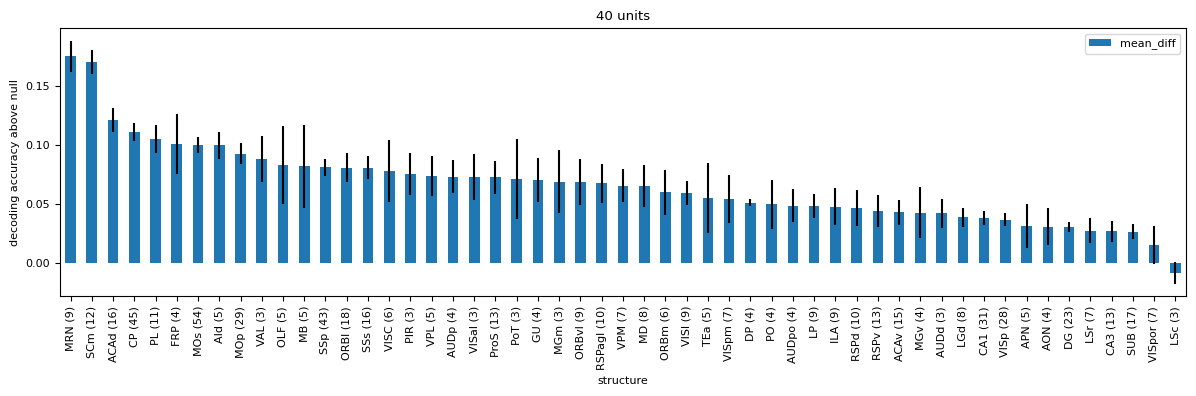

In [77]:
for uu in new_results_pd['unit_subsample_size'].unique():
    fig,ax=plt.subplots(1,1,figsize=(12,4))
    structure_labels=[]
    if np.isnan(uu):
        plot_data=new_results_pd.query('unit_subsample_size.isna()').sort_values(by='mean_diff',ascending=False)
        plot_data.plot.bar(ax=ax,x='structure',y=['mean_diff'],yerr='sem_diff',rot=90)
        title_str='All units'
        for i in range(plot_data.shape[0]):
            structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(int(plot_data['num_sessions'].iloc[i]))+')')
    else:
        plot_data=new_results_pd.query('unit_subsample_size==@uu').sort_values(by='mean_diff',ascending=False)
        plot_data.plot.bar(ax=ax,x='structure',y=['mean_diff'],yerr='sem_diff',rot=90)
        title_str=f'{int(uu)} units'
        for i in range(plot_data.shape[0]):
            structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(int(plot_data['num_sessions'].iloc[i]))+')')

    
    ax.set_ylabel('decoding accuracy above null')
    ax.set_title(title_str)
    ax.set_xticklabels(structure_labels,rotation=90,ha='center')
    fig.tight_layout()


In [73]:
plot_data['structure']


0      SCiw
6       SCm
32       CP
21     SCig
14      GPe
       ... 
398     SNc
404     LSc
403     PVT
409      NB
410      IG
Name: structure, Length: 121, dtype: object

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11992\1113238468.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11992\1113238468.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11992\1113238468.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11992\1113238468.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11992\1113238468.py:30: RuntimeWarning: invalid 

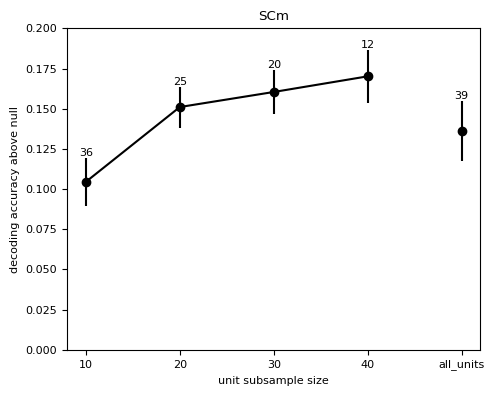

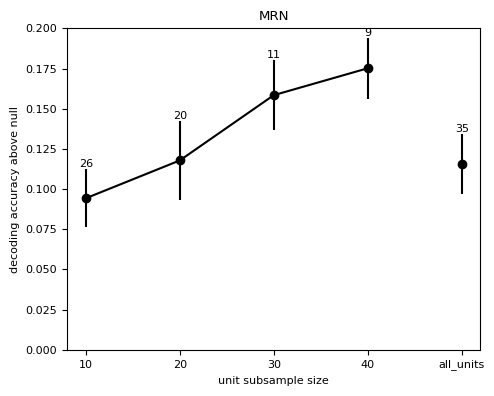

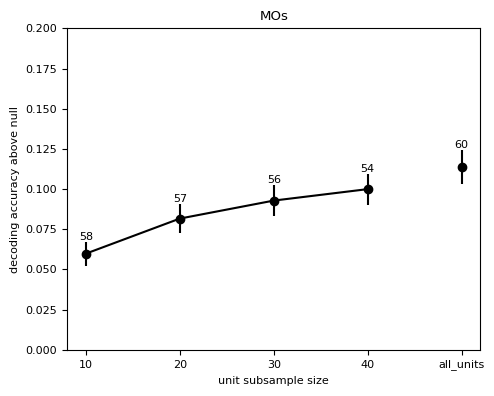

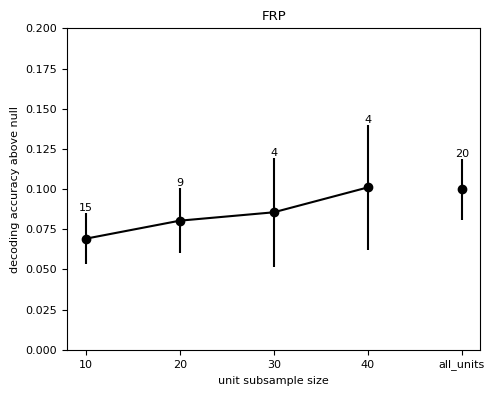

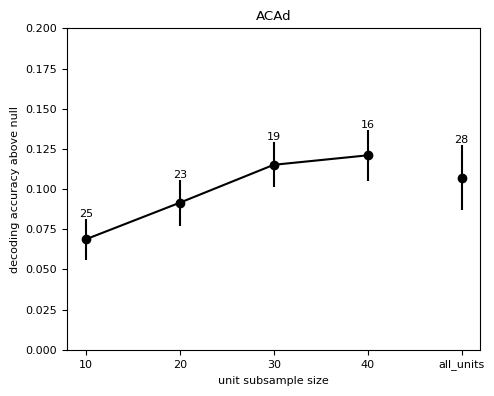

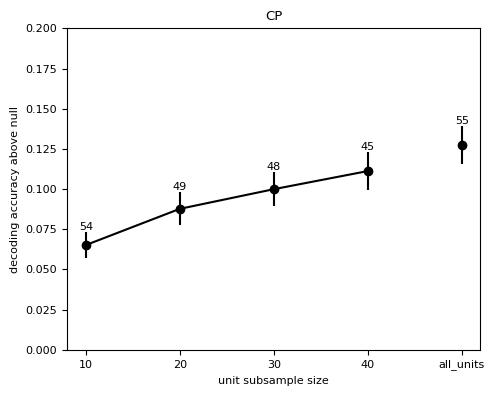

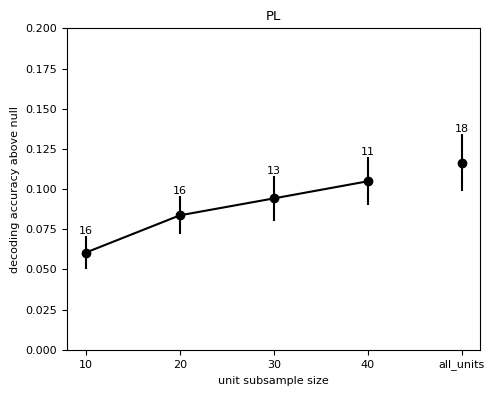

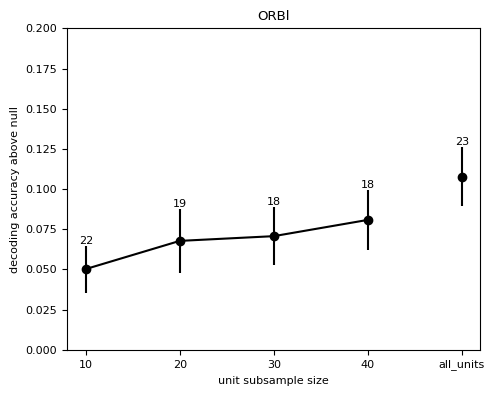

In [61]:
#accuracy vs. n units for a subset of structures
sel_structures=['SCm','MRN','MOs','FRP','ACAd','CP','PL','ORBl']

for ss in sel_structures:
    fig,ax=plt.subplots(1,1,figsize=(5,4))
    plot_data=new_results_pd.query('structure==@ss').sort_values(by='mean_diff',ascending=True)

    ax.errorbar(plot_data.query('~unit_subsample_size.isna()')['unit_subsample_size'],
                plot_data.query('~unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('~unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    ax.errorbar(np.nanmax(plot_data['unit_subsample_size'])+10,
                plot_data.query('unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    
    for uu in plot_data['unit_subsample_size'].unique():
        if np.isnan(uu):
            xcoord=np.nanmax(plot_data['unit_subsample_size'])+10
            ycoord=plot_data.query('unit_subsample_size.isna()')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size.isna()')['num_sessions'].values[0]
        else:
            xcoord=uu
            ycoord=plot_data.query('unit_subsample_size==@uu')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size==@uu')['num_sessions'].values[0]

        ax.text(xcoord,ycoord,temp_str,ha='center',va='bottom')

    ax.set_ylabel('decoding accuracy above null')
    ax.set_xlabel('unit subsample size')
    ax.set_xticks(plot_data['unit_subsample_size'].unique().tolist()+[np.nanmax(plot_data['unit_subsample_size'])+10])
    ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
    ax.set_title(ss)
    ax.set_ylim([0,0.2])
    fig.tight_layout()

In [ ]:
# example areas: true vs. null decoding accuracy

In [ ]:
# plot on CCF?

In [ ]:
# correlate session-wise accuracy with cross-modal dprime

# compare correlation across areas?

In [ ]:
# supplemental: plot shifts, null, etc. for a few example sessions

# also average across sessions

In [ ]:
# templeton comparison

In [ ]:
# trialwise predict proba stuff:

# show individual repeats, averages over repeats, etc.

# session examples - point out errors etc.

# response type averages

# switch aligned

# outcome changes

# correlations between structures (how dependent on different repeats/samples?)